## Imports

In [114]:
from __future__ import division, print_function, absolute_import
import os
import sys
import numpy as np
import matplotlib.pyplot as plt
import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset, TensorDataset
from math import ceil
from scipy.ndimage.interpolation import map_coordinates
from scipy.ndimage.filters import gaussian_filter
import pickle

## Mount drive if necessary

In [2]:
from google.colab import drive
drive.mount('gdrive/')
# os.chdir('gdrive/My Drive/Colab Notebooks/FACT/')
# '/gdrive/My Drive/Colab Notebooks/NLP1/Practical 2/googlenews.word2vec.300d.txt'

ModuleNotFoundError: No module named 'google'

In [ ]:
os.chdir('gdrive/My Drive/Colab Notebooks/FACT/')

## Helper functions
Helper functions borrowed from original paper by Li et al. 

In [8]:
def makedirs(path):
    '''
    if path does not exist in the file system, create it
    '''
    if not os.path.exists(path):
        os.makedirs(path)

def list_of_norms(X):
    '''
    X is a list of vectors X = [x_1, ..., x_n], we return
        [d(x_1, x_1), d(x_2, x_2), ... , d(x_n, x_n)], where the distance
    function is the squared euclidean distance.
    '''
    return torch.sum(torch.pow(X, 2), dim=1)

def print_and_write(str, file):
    '''
    print str to the console and also write it to file
    '''
    print(str)
    file.write(str + '\n')

In [9]:
os.getcwd()

'/Users/TomLotze/Documents/Artificial Intelligence/Year 1/FACT/FACT/Reproduction'

## Create necessary folders

In [182]:
# data folder
makedirs('./data/cifar/')
cifar_folder = "./data/cifar/"
# for b in range(1, 6):
#     makedirs(os.path.join(cifar_folder, 'data_batch_' + str(b)))


# Models folder
model_folder = os.path.join(os.getcwd(), "saved_model", "cifar_model")
makedirs(model_folder)

# Image folder
img_folder = os.path.join(model_folder, "img")
makedirs(img_folder)

# ci

# Model filename
model_filename = "cifar_cae"

## Dataset - Pytorch
#### <font color='red'>Double check the normalization mean and stdev for dataset</font>
#### <font color='red'>Double check parameters Dataloader (e.g. shuffle on or off, different batch sizes for train/valid/test)</font>

In [185]:
# borrowed from deep learning assignment


def load_cifar10_batch(batch_filename):
    """
    Loads single batch of CIFAR10 data.
    Args:
    batch_filename: Filename of batch to get data from.
    Returns:
    X: CIFAR10 batch data in numpy array with shape (10000, 32, 32, 3).
    Y: CIFAR10 batch labels in numpy array with shape (10000, ).
    """
    with open(batch_filename, 'rb') as f:
        batch = pickle.load(f, encoding='latin1')
        X = batch['data']
        Y = batch['labels']
        X = X.reshape(10000, 3, 32, 32).transpose(0,2,3,1).astype(np.float32)
        Y = np.array(Y)
        return X, Y

def load_cifar10(cifar10_folder):
    """
    Loads CIFAR10 train and test splits.
    Args:
    cifar10_folder: Folder which contains downloaded CIFAR10 data.
    Returns:
    X_train: CIFAR10 train data in numpy array with shape (50000, 32, 32, 3).
    Y_train: CIFAR10 train labels in numpy array with shape (50000, ).
    X_test: CIFAR10 test data in numpy array with shape (10000, 32, 32, 3).
    Y_test: CIFAR10 test labels in numpy array with shape (10000, ).

    """
    Xs = []
    Ys = []
    for b in range(1, 6):
        batch_filename = os.path.join(cifar10_folder, 'data_batch_' + str(b))
        X, Y = load_cifar10_batch(batch_filename)
        Xs.append(X)
        Ys.append(Y)
    X_train = np.concatenate(Xs)
    Y_train = np.concatenate(Ys)
    X_test, Y_test = load_cifar10_batch(os.path.join(cifar10_folder, 'test_batch'))
    return X_train, Y_train, X_test, Y_test

def get_cifar10_raw_data(data_dir):
    """
    Gets raw CIFAR10 data from http://www.cs.toronto.edu/~kriz/cifar-10-python.tar.gz.

    Args:
    data_dir: Data directory.
    Returns:
    X_train: CIFAR10 train data in numpy array with shape (50000, 32, 32, 3).
    Y_train: CIFAR10 train labels in numpy array with shape (50000, ).
    X_test: CIFAR10 test data in numpy array with shape (10000, 32, 32, 3).
    Y_test: CIFAR10 test labels in numpy array with shape (10000, ).
    """

    X_train, Y_train, X_test, Y_test = load_cifar10(data_dir)
    return X_train, Y_train, X_test, Y_test

def preprocess_cifar10_data(X_train_raw, Y_train_raw, X_test_raw, Y_test_raw):
    """
    Preprocesses CIFAR10 data by substracting mean from all images.
    Args:
    X_train_raw: CIFAR10 raw train data in numpy array.
    Y_train_raw: CIFAR10 raw train labels in numpy array.
    X_test_raw: CIFAR10 raw test data in numpy array.
    Y_test_raw: CIFAR10 raw test labels in numpy array.
    num_val: Number of validation samples.
    Returns:
    X_train: CIFAR10 train data in numpy array.
    Y_train: CIFAR10 train labels in numpy array.
    X_test: CIFAR10 test data in numpy array.
    Y_test: CIFAR10 test labels in numpy array.
    """
    X_train = X_train_raw.copy()
    Y_train = Y_train_raw.copy()
    X_test = X_test_raw.copy()
    Y_test = Y_test_raw.copy()

    # Substract the mean
#     mean_image = np.mean(X_train, axis=0)
#     X_train -= mean_image
#     X_test -= mean_image
    
    # Transpose
    X_train = np.transpose(X_train, (0, 3, 1, 2))
    X_test = np.transpose(X_test, (0, 3, 1, 2))

    return X_train, Y_train, X_test, Y_test

def dense_to_one_hot(labels_dense, num_classes):
    """
    Convert class labels from scalars to one-hot vectors.
    Args:
    labels_dense: Dense labels.
    num_classes: Number of classes.
    Returns:
    labels_one_hot: One-hot encoding for labels.
    """
    num_labels = labels_dense.shape[0]
    index_offset = np.arange(num_labels) * num_classes
    labels_one_hot = np.zeros((num_labels, num_classes))
    labels_one_hot.flat[index_offset + labels_dense.ravel()] = 1
    return labels_one_hot

class DataSet(object):
    """
    Utility class to handle dataset structure.
    """

    def __init__(self, images, labels):
        """
        Builds dataset with images and labels.
        Args:
        images: Images data.
        labels: Labels data
        """
        assert images.shape[0] == labels.shape[0], (
          "images.shape: {0}, labels.shape: {1}".format(str(images.shape), str(labels.shape)))

        self._num_examples = images.shape[0]
        self._images = images
        self._labels = labels
        self._epochs_completed = 0
        self._index_in_epoch = 0

    @property
    def images(self):
        return self._images

    @property
    def labels(self):
        return self._labels

    @property
    def num_examples(self):
        return self._num_examples

    @property
    def epochs_completed(self):
        return self._epochs_completed

    def next_batch(self, batch_size):
        """
        Return the next `batch_size` examples from this data set.
        Args:
        batch_size: Batch size.
        """
        start = self._index_in_epoch
        self._index_in_epoch += batch_size
        if self._index_in_epoch > self._num_examples:
            self._epochs_completed += 1

            perm = np.arange(self._num_examples)
            np.random.shuffle(perm)
            self._images = self._images[perm]
            self._labels = self._labels[perm]

            start = 0
            self._index_in_epoch = batch_size
            assert batch_size <= self._num_examples

        end = self._index_in_epoch
        return self._images[start:end], self._labels[start:end]

def read_data_sets(data_dir, one_hot = True, validation_size = 5000):
    """
    Returns the dataset readed from data_dir.
    Uses or not uses one-hot encoding for the labels.
    Subsamples validation set with specified size if necessary.
    Args:
    data_dir: Data directory.
    one_hot: Flag for one hot encoding.
    validation_size: Size of validation set
    Returns:
    Dictionary with Train, Validation, Test Datasets
    """
    # Extract CIFAR10 data
    train_images_raw, train_labels_raw, test_images_raw, test_labels_raw = \
        get_cifar10_raw_data(data_dir)
    train_images, train_labels, test_images, test_labels = \
        preprocess_cifar10_data(train_images_raw, train_labels_raw, test_images_raw, test_labels_raw)

    # Apply one-hot encoding if specified
    if one_hot:
        num_classes = len(np.unique(train_labels))
        train_labels = dense_to_one_hot(train_labels, num_classes)
        test_labels = dense_to_one_hot(test_labels, num_classes)

    # Subsample the validation set from the train set
    if not 0 <= validation_size <= len(train_images):
        raise ValueError("Validation size should be between 0 and {0}. Received: {1}.".format(
            len(train_images), validation_size))

    validation_images = train_images[:validation_size]
    validation_labels = train_labels[:validation_size]
    train_images = train_images[validation_size:]
    train_labels = train_labels[validation_size:]

    # Create datasets
    train = DataSet(train_images, train_labels)
    validation = DataSet(validation_images, validation_labels)
    test = DataSet(test_images, test_labels)

    return {'train': train, 'validation': validation, 'test': test}

def get_cifar10(data_dir = cifar_folder, one_hot = True, validation_size = 5000):
    """
    Prepares CIFAR10 dataset.
    Args:
    data_dir: Data directory.
    one_hot: Flag for one hot encoding.
    validation_size: Size of validation set
    Returns:
    Dictionary with Train, Validation, Test Datasets
    """
    return read_data_sets(data_dir, one_hot, validation_size)


In [186]:
# extract cifar data
batch_size = 250
data = get_cifar10(cifar_folder, one_hot=False)

# extract training,validation and test data
X_train, Y_train = torch.from_numpy(data['train'].images), torch.from_numpy(data['train'].labels)
X_validation, Y_validation = torch.from_numpy(data['validation'].images), torch.from_numpy(data['validation'].labels)
X_test, Y_test = torch.from_numpy(data['test'].images), torch.from_numpy(data['test'].labels)

# create datasets
train_data = TensorDataset(X_train, Y_train)
valid_data = TensorDataset(X_validation, Y_validation)
test_data = TensorDataset(X_test, Y_test)
                                  
                                  

In [187]:
print(type(X_train))

<class 'torch.Tensor'>


In [188]:
print(data['train'].images.shape)

(45000, 3, 32, 32)


## Parameters

In [189]:
# COPIED FROM THE ORIGINAL IMPLEMENTATION
# training parameters
learning_rate = 0.002
training_epochs = 1500

# frequency of testing and saving
test_display_step = 5    # how many epochs we do evaluate on the test set once, default 100
save_step = 50            # how frequently do we save the model to disk

# elastic deformation parameters
sigma = 4
alpha = 20

# lambda's are the ratios between the four error terms
lambda_class = 20
lambda_ae = 1 # autoencoder
lambda_1 = 1 # push prototype vectors to have meaningful decodings in pixel space
lambda_2 = 1 # cluster training examples around prototypes in latent space


input_height = input_width =  32   # MNIST data input shape 
n_input_channel = 3     # the number of color channels; for MNIST is 1.
input_size = input_height * input_width * n_input_channel   # 784
n_classes = 10

# Network Parameters
n_prototypes = 15         # the number of prototypes
n_layers = 4

# height and width of each layers' filters
f_1 = 3
f_2 = 3
f_3 = 3
f_4 = 3

# stride size in each direction for each of the layers
s_1 = 2
s_2 = 2
s_3 = 2
s_4 = 2

# number of feature maps in each layer
n_map_1 = 32
n_map_2 = 32
n_map_3 = 32
n_map_4 = 10

# the shapes of each layer's filter
# [out channel, in_channel, 3, 3]
filter_shape_1 = [n_map_1, n_input_channel, f_1, f_1]
filter_shape_2 = [n_map_2, n_map_1, f_2, f_2]
filter_shape_3 = [n_map_3, n_map_2, f_3, f_3]
filter_shape_4 = [n_map_4, n_map_3, f_4, f_4]

# strides for each layer (changed to tuples)
stride_1 = [s_1, s_1]
stride_2 = [s_2, s_2]
stride_3 = [s_3, s_3]
stride_4 = [s_4, s_4]


## Model construction
#### <font color='red'>Fix the stride and padding parameters, check if filter in tf is same as weight in pt</font>
Padding discussion pytorch: https://github.com/pytorch/pytorch/issues/3867

Blogpost: https://mmuratarat.github.io/2019-01-17/implementing-padding-schemes-of-tensorflow-in-python

In [190]:
class Encoder(nn.Module):
    '''Encoder'''
    def __init__(self):
        super(Encoder, self).__init__()
        
        # height and width of each layers' filters
        f_1 = 3
        f_2 = 3
        f_3 = 3
        f_4 = 3
        
        # define layers
        self.enc_l1 = nn.Conv2d(3, 32, kernel_size=3, stride=2, padding=0)
        self.enc_l2 = nn.Conv2d(32, 32, kernel_size=3, stride=2, padding=0)
        self.enc_l3 = nn.Conv2d(32, 32, kernel_size=3, stride=2, padding=0)
        self.enc_l4 = nn.Conv2d(32, 10, kernel_size=3, stride=2, padding=0)
        self.relu = nn.ReLU()
        self.sigmoid = nn.Sigmoid()
        
        
    def pad_image(self, img):
        ''' Takes an input image (batch) and pads according to Tensorflows SAME padding'''
        input_h = img.shape[2]
        input_w = img.shape[3]
        stride = 2 
        filter_h = 3
        filter_w = 3

        output_h = int(ceil(float(input_h)) / float(stride))
        output_w = output_h

        if input_h % stride == 0:
            pad_height = max((filter_h - stride), 0)
        else:
            pad_height = max((filter_h - (input_h % stride), 0))

        pad_width = pad_height

        pad_top = pad_height // 2
        pad_bottom = pad_height - pad_top
        pad_left = pad_width // 2
        pad_right = pad_width - pad_left

        padded_img = torch.zeros(img.shape[0], img.shape[1], input_h + pad_height, input_w + pad_width)
        padded_img[:,:, pad_top:-pad_bottom, pad_left:-pad_right] = img

        return padded_img
        
    def forward(self, x):
        pad_x = self.pad_image(x)
        el1 = self.relu(self.enc_l1(pad_x))
        
        pad_el1 = self.pad_image(el1)
        el2 = self.relu(self.enc_l2(pad_el1))
    
        pad_el2 = self.pad_image(el2)
        el3 = self.relu(self.enc_l3(pad_el2))
        
        pad_el3 = self.pad_image(el3)
        el4 = self.relu(self.enc_l4(pad_el3))
        
        return el4
        
class Decoder(nn.Module):
    '''Decoder'''
    def __init__(self):
        super(Decoder, self).__init__()
        # height and width of each layers' filters
        f_1 = 3
        f_2 = 3
        f_3 = 3
        f_4 = 3

        # define layers
        self.dec_l4 = nn.ConvTranspose2d(10, 32, kernel_size=3, stride=2, padding=1, output_padding=1)
        self.dec_l3 = nn.ConvTranspose2d(32, 32, kernel_size=3, stride=2, padding=1, output_padding=1)
        self.dec_l2 = nn.ConvTranspose2d(32, 32, kernel_size=3, stride=2, padding=1, output_padding=1)
        self.dec_l1 = nn.ConvTranspose2d(32, 3, kernel_size=3, stride=2, padding=1, output_padding=1)

        self.relu = nn.ReLU()
        self.sigmoid = nn.Sigmoid()

    def forward(self, enc_x):
        dl4 = self.relu(self.dec_l4(enc_x))
        dl3 = self.relu(self.dec_l3(dl4))
        dl2 = self.relu(self.dec_l2(dl3))
        decoded_x = self.sigmoid(self.dec_l1(dl2))
        
        return decoded_x


class nn_prototype(nn.Module):
    '''Model'''
    def __init__(self, n_prototypes=15, n_layers=4, n_classes=10):
        super().__init__()
        
        self.encoder = Encoder()
        self.decoder = Decoder()
        
        # initialize prototype - currently not in correct spot
        n_features = 40 # size of encoded x - 250 x 10 x 2 x 2
        self.prototype_feature_vectors = nn.Parameter(torch.empty(size=(n_prototypes, n_features), 
                                                                  dtype=torch.float32).uniform_())
        
        self.last_layer = nn.Linear(n_prototypes,10)
        
    def list_of_distances(self, X, Y):
        '''
        Given a list of vectors, X = [x_1, ..., x_n], and another list of vectors,
        Y = [y_1, ... , y_m], we return a list of vectors
                [[d(x_1, y_1), d(x_1, y_2), ... , d(x_1, y_m)],
                 ...
                 [d(x_n, y_1), d(x_n, y_2), ... , d(x_n, y_m)]],
        where the distance metric used is the sqared euclidean distance.
        The computation is achieved through a clever use of broadcasting.
        '''
        XX = torch.reshape(self.list_of_norms(X), shape=(-1, 1))
        YY = torch.reshape(self.list_of_norms(Y), shape=(1, -1))
        output = XX + YY - 2 * torch.mm(X, Y.t())

        return output

    def list_of_norms(self, X):
        '''
        X is a list of vectors X = [x_1, ..., x_n], we return
            [d(x_1, x_1), d(x_2, x_2), ... , d(x_n, x_n)], where the distance
        function is the squared euclidean distance.
        '''
        return torch.sum(torch.pow(X, 2), dim=1)
    
    def forward(self, x):
        
        #print("shape of x at start of forward pass", x.shape)
        
        #encoder step
        enc_x = self.encoder(x)
        
        #print("dimensions of encoded x", enc_x.shape)
        
        #decoder step
        dec_x = self.decoder(enc_x)
        
        #print("shape of decoded x", dec_x.shape)
        
        # hardcoded input size HERE IS AN ERROR FOR CIFAR
        dec_x = dec_x.view(x.shape[0], x.shape[1], x.shape[2], x.shape[3])
        
        # flatten encoded x to compute istance with prototypes
        n_features = enc_x.shape[1] * enc_x.shape[2] * enc_x.shape[3]
        feature_vectors_flat = torch.reshape(enc_x, shape=[-1, n_features])
        
        # distance to prototype
        prototype_distances = self.list_of_distances(feature_vectors_flat, self.prototype_feature_vectors)
        
        # distance to feature vectors
        feature_vector_distances = self.list_of_distances(self.prototype_feature_vectors, feature_vectors_flat)
        
        # classification layer
        logits = self.last_layer(prototype_distances)
        
        # Softmax to prob dist not needed as cross entropy loss is used?
        
        return dec_x, logits, feature_vector_distances, prototype_distances
        

## Cost function

In [191]:
'''
the error function consists of 4 terms, the autoencoder loss,
the classification loss, and the two requirements that every feature vector in
X look like at least one of the prototype feature vectors and every prototype
feature vector look like at least one of the feature vectors in X.
'''
def loss_function(X_decoded, X_true, logits, Y, feature_dist, prototype_dist, lambdas=None, print_flag=False):
    if lambdas == None:
        lambda_class, lambda_ae, lambda_1, lambda_2 = 20, 1, 1, 1
    
    ae_error = torch.mean(list_of_norms(X_decoded - X_true))
#     ae_error = F.binary_cross_entropy(X_decoded, X_true)
    class_error = F.cross_entropy(logits, Y, reduction="mean")
    error_1 = torch.mean(torch.min(feature_dist, axis=1)[0])
    error_2 = torch.mean(torch.min(prototype_dist, axis = 1)[0])

    # total_error is the our minimization objective
    total_error = lambda_class * class_error +\
                  lambda_ae * ae_error + \
                  lambda_1 * error_1 + \
                  lambda_2 * error_2
    
    if print_flag == True:
        print('AE error: ', ae_error)
    return total_error

## Accuracy

In [192]:
def compute_acc(logits, labels):
    batch_size = labels.shape[0]
    predictions = logits.argmax(dim=1)
    total_correct = torch.sum(predictions == labels).item()
    accuracy = total_correct / batch_size
    
    return(accuracy)

### Elastic deformation

In [193]:
def batch_elastic_transform(images, sigma, alpha, height, width, random_state=None):
    '''
    this code is borrowed from chsasank on GitHubGist
    Elastic deformation of images as described in [Simard 2003].
    
    images: a two-dimensional numpy array; we can think of it as a list of flattened images
    sigma: the real-valued variance of the gaussian kernel
    alpha: a real-value that is multiplied onto the displacement fields
    
    returns: an elastically distorted image of the same shape
    '''
    images = images.view(images.shape[0], -1).numpy()
    assert len(images.shape) == 2

    # the two lines below ensure we do not alter the array images
    e_images = np.empty_like(images)
    e_images[:] = images
    
    e_images = e_images.reshape(-1, height, width)
    
    if random_state is None:
        random_state = np.random.RandomState(None)
    x, y = np.mgrid[0:height, 0:width]
    
    for i in range(e_images.shape[0]):
        
        dx = gaussian_filter((random_state.rand(height, width) * 2 - 1), sigma, mode='constant') * alpha
        dy = gaussian_filter((random_state.rand(height, width) * 2 - 1), sigma, mode='constant') * alpha
        indices = x + dx, y + dy
        e_images[i] = map_coordinates(e_images[i], indices, order=1)

    return e_images.reshape(images.shape[0], 1, 32, 32)

In [194]:
def visualize_prototypes(model, epoch, save=True):
    # get saved prototypes
    encoded_prototypes = model.prototype_feature_vectors
    encoded_prototypes_reshaped = encoded_prototypes.view(n_prototypes, 10, 2, 2)

    # decode prototypes
    decoded_prototypes = model.decoder(encoded_prototypes_reshaped).squeeze().detach().numpy()

    for i in range(n_prototypes):
        plt.imshow(decoded_prototypes[i].transpose(1, 2, 0))
        if save:
            makedirs(img_folder+"/prototypes_epoch_"+ str(epoch))
            plt.savefig(img_folder+"/prototypes_epoch_"+ str(epoch)+"/"+str(i)+".png")
        else:
            plt.show()

## Training loop

In [ ]:
model = nn_prototype(15,4,10)
batch_size_ = 250

# get validation and test set
valid_dl = DataLoader(valid_data, batch_size=5000, drop_last=False, shuffle=True)
test_dl = DataLoader(test_data, batch_size=10000, drop_last=False, shuffle=True)

# initialize optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

# initialize storage for results
train_accs = []
train_losses = []
test_accs = []
test_losses = []
valid_accs = []
valid_losses = []

# training loop
for epoch in range(training_epochs):
    print("\nEpoch:", epoch)

    train_dl = DataLoader(train_data, batch_size=batch_size_, drop_last=False, shuffle=True)


    # loop over the batches
    for step, (x, Y) in enumerate(train_dl):
        optimizer.zero_grad()
        
        Y = Y.long()
        
        # think about normalization for x, its already centered by preprocessing in loading cifar
        x /= 255
        
        print(x.max(), x.min(), x.mean())
                
        # perform forward pass
        X_decoded, logits, feature_dist, prot_dist = model(x)

        # compute the loss
        total_loss = loss_function(X_decoded, x, logits, Y, feature_dist, prot_dist)

        # backpropagate over the loss
        total_loss.backward()

        # update the weights
        optimizer.step()

    # compute and save accuracy and loss
    train_accuracy = compute_acc(logits, Y)
    train_accs.append(train_accuracy)
    train_losses.append(total_loss.item())

    # print information
    print('Train loss:', total_loss.item())
    print('Train acc:', train_accuracy)


    if epoch % test_display_step == 0:
        # save model and prototypes
        torch.save(model, model_folder + "/" + model_filename + "_epoch_" + str(epoch) + '.pt')
        print("model is saved")
        
        # save model prototypes
        visualize_prototypes(model, epoch, save = True)
        
        # perform testing
        with torch.no_grad():
            for step, (x_test, y_test) in enumerate(test_dl):
                x_test /=  255
                    
                # forward pass
                X_decoded, logits, feature_dist, prot_dist = model(x_test)

                # compute loss and accuracy and save
                test_accuracy = compute_acc(logits, y_test)
                test_loss = loss_function(X_decoded, x_test, logits, y_test, feature_dist, prot_dist)
                test_accs.append(test_accuracy)
                test_losses.append(test_loss)

            print('\nTest loss:', test_loss.item())
            print('Test acc:', test_accuracy)

    # validation
    with torch.no_grad():
        for step, (x_valid, y_valid) in enumerate(valid_dl):
                x_valid /= 255
                X_decoded, logits, feature_dist, prot_dist = model(x_valid)

                # compute losses and accuracy and save
                valid_accuracy = compute_acc(logits, y_valid)
                valid_loss = loss_function(X_decoded, x_valid, logits, y_valid, feature_dist, prot_dist)
                valid_accs.append(valid_accuracy)
                valid_losses.append(valid_loss)

        print('\nValid loss:', valid_loss.item())
        print('Valid acc:', valid_accuracy)
    



Epoch: 0
Train loss: 44.45993423461914
Train acc: 0.272
model is saved

Test loss: 43.914974212646484
Test acc: 0.2676

Valid loss: 43.84764099121094
Valid acc: 0.2726

Epoch: 1


## Loading the model and visualize prototypes

In [0]:
# load the model
loaded_model = torch.load(model_folder+"/"+model_filename)

with torch.no_grad():
        for step, (x_valid, y_valid) in enumerate(valid_dl):
                x_valid = x_valid.view(x_valid.shape[0], 1, x_valid.shape[1], x_valid.shape[2]).float()
                X_decoded, logits, feature_dist, prot_dist = loaded_model(x_valid)

                # Check is model is indeed trained
                valid_accuracy = compute_acc(logits, y_valid)
                valid_loss = loss_function(X_decoded, x_valid, logits, y_valid, feature_dist, prot_dist)

        print('\nValid loss:', valid_loss.item())
        print('Valid acc:', valid_accuracy)

visualize_prototypes(loaded_model, 1, False)

In [ ]:
# visualize prototypes from current model (not the loaded one)
visualize_prototypes(model, 1, 0)

## Saving and plotting of losses and accuracies

---



In [0]:
import pickle 

with open(model_folder + '/train_accs.p', 'wb') as f:
    pickle.dump(train_accs, f)

with open(model_folder + '/test_accs.p', 'wb') as f:
    pickle.dump(test_accs, f)

with open(model_folder + '/valid_accs.p', 'wb') as f:
    pickle.dump(valid_accs, f)

with open(model_folder + '/train_losses.p', 'wb') as f:
    pickle.dump(train_losses, f)

with open(model_folder + '/test_losses.p', 'wb') as f:
    pickle.dump(test_losses, f)

with open(model_folder + '/valid_losses.p', 'wb') as f:
    pickle.dump(valid_losses, f)

231


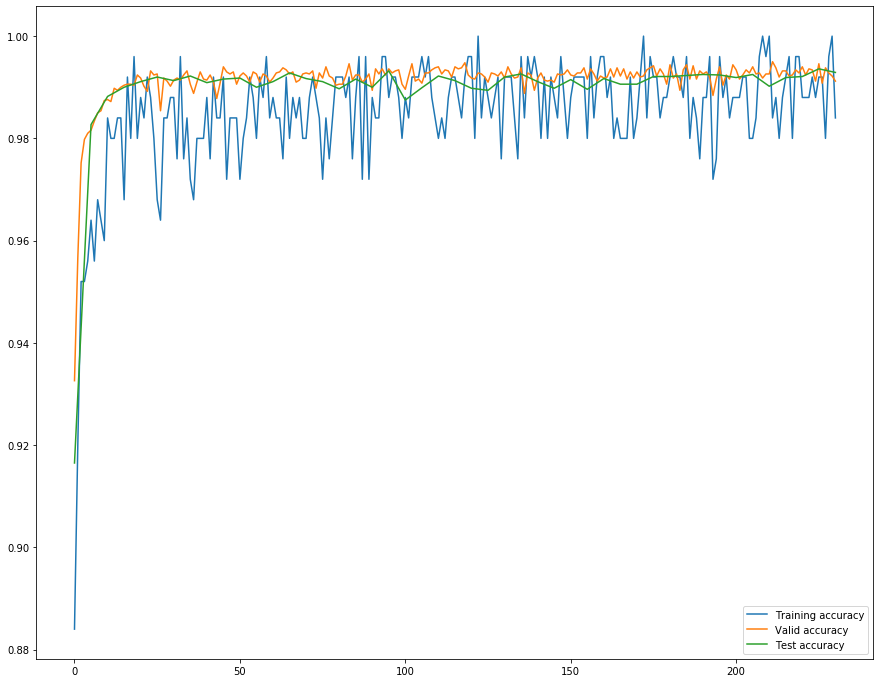

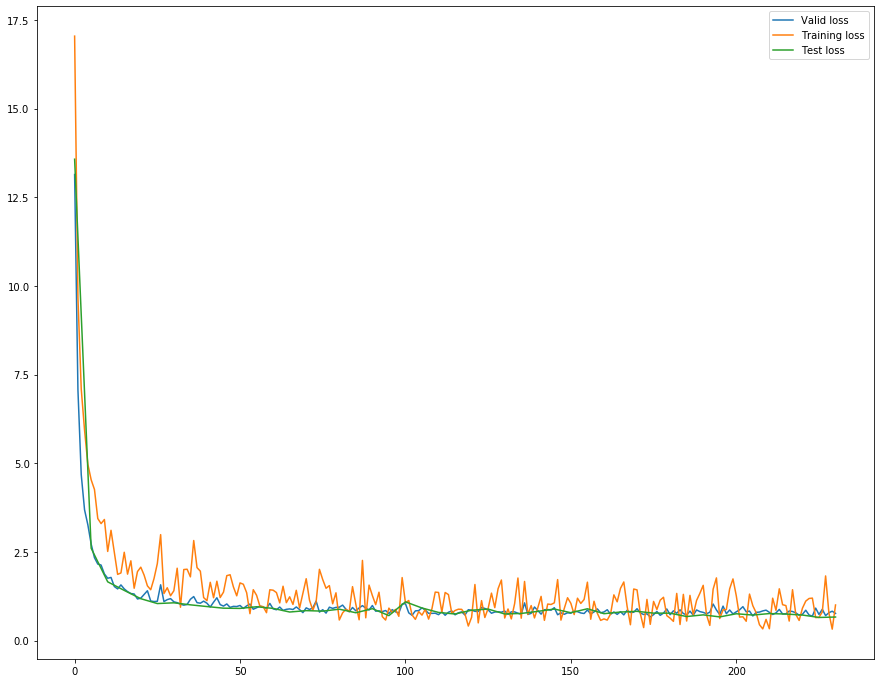

In [37]:
v_t_epochs = list(range(0,len(train_accs)))
test_epochs = list(range(0,len(train_accs),test_display_step))
print(len(train_accs))
plt.figure(figsize=(15,12))
plt.plot(v_t_epochs, train_accs, label="Training accuracy")
plt.plot(v_t_epochs, valid_accs, label="Valid accuracy")
plt.plot(test_epochs, test_accs, label="Test accuracy")
plt.legend()
plt.show()

plt.figure(figsize=(15,12))
plt.plot(v_t_epochs, valid_losses, label="Valid loss")
plt.plot(v_t_epochs, train_losses, label="Training loss")
plt.plot(test_epochs, test_losses, label="Test loss")
plt.legend()
plt.show()